In [16]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

import os
os.chdir('/gdrive/MyDrive/Colab Notebooks/DDPS_Test')

Mounted at /gdrive


In [37]:
# Option.py --------------------------------------------------------------------

#import argparse
import os
import torch
import numpy as np
import datetime
from PIL import Image
import sys
current_working_directory = os.getcwd()
sys.path.append(current_working_directory + '/models')

class Options:
    def __init__(self,epoch,pattern):
        self.name = 'debug'
        self.num_threads = 0
        self.n_epoch = epoch
        self.batch_size = 2
        self.batch_size_valid = 2
        self.valid_N = 2
        self.batch_size_test = 1
        self.freq_print = 1
        self.freq_valid = 10
        self.light_N = 4
        self.initial_pattern = pattern
        self.used_loss = 'cosine'
        self.lr_light = 3e-1
        self.lr_pixel = 1.5e-2
        self.lr_translate = 1e-2
        self.lr_rotate = 1e-2
        self.lr_decay_light = 0.3
        self.step_size_light = 10
        self.fix_light_pattern = False
        self.fix_light_position = False
        self.load_epoch = 0
        self.load_step_start = 0
        self.load_latest = False
        self.dataset_root = './Dataset_12x6_C/'
        self.save_dir = './results/'
        self.light_geometric_calib_fn = './calibration/monitor_pixels_h12w6.npy' #'./calibration/monitor_pixels_h16w9.npy' / './calibration/monitor_pixels_h9w16.npy'
        self.load_monitor_light = False
        self.light_fn = ''
        self.pt_ref_x = 0.
        self.pt_ref_y = 0.
        self.pt_ref_z = 0.1 #0.1 / 0.5
        self.resizing_factor = 1
        self.cam_R = 608 #608 / 512
        self.cam_C = 456 #456 / 612
        self.usePatch = False
        self.roi_min_c = 511
        self.roi_min_r = 288
        self.roi_width = 200
        self.roi_height = 200
        self.cam_focal_length_pix = 8.110470904e+5 #8.110470904e+5 / 1.1485e+3
        self.cam_pitch = 1.0315e-5 #1.0315e-5 / 3.45e-6*2
        self.cam_gain = 0.0
        self.cam_gain_base = 1.0960
        self.static_interval = 1/24
        self.noise_sigma = 0.02
        self.rendering_scalar = 3.25 #5.681e2/28 / 1.3e2/40
        self.light_R = 12 # 16 / 9
        self.light_C = 6 # 9 / 16
        self.light_pitch = 0.315e-3 * 120 * 2
        self.monitor_gamma = 2.2
        self.vertical_gap = 226.8 * 1e-3 / 3
        self.horizontal_gap = 80.64 * 1e-3
        self.weight_normal = 1
        self.weight_recon = 5
        self.Gaussian_sigma = 5

        self.initialized = True

    def parse(self, save=True, isTrain=True, parse_args=None):
        if not self.initialized:
            self.initialize()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ## gpu cuda 연산 가능시 사용함 (불가능하면 cpu로 대신 연산)
        self.dtype = torch.float32 ## float32 type

        self.cam_focal_length = self.cam_focal_length_pix * self.cam_pitch

        self.cam_shutter_time = self.static_interval / self.light_N

        self.original_R = self.cam_R
        self.original_C = self.cam_C

        self.cam_R //= self.resizing_factor
        self.cam_C //= self.resizing_factor
        self.cam_pitch *= self.resizing_factor

        if not self.usePatch:
            self.roi_height = self.cam_R
            self.roi_width = self.cam_C

        # Dataset paths
        self.dataset_train_root = os.path.join(self.dataset_root, 'train') ## for training dataset
        self.dataset_test_root = os.path.join(self.dataset_root, 'val') ## for vailidation dataset
        self.tb_dir = os.path.join(self.save_dir, self.name, datetime.datetime.now().strftime("%Y%m%d_%H%M%S")) ## Output 폴더 생성
        if not os.path.exists(self.tb_dir):
            os.makedirs(self.tb_dir)
            os.makedirs(os.path.join(self.tb_dir, 'patterns'))
            os.makedirs(os.path.join(self.tb_dir, 'positions'))
            os.makedirs(os.path.join(self.tb_dir, 'validation'))
            os.makedirs(os.path.join(self.tb_dir, 'model_imgs'))


        print('------------ Options -------------')
        args = vars(self)
        print('-------------- End ----------------')

        if save:
            file_name = os.path.join(self.tb_dir, 'opt.txt')
            with open(file_name, 'wt') as opt_file:
                opt_file.write('------------ Options -------------\n')
                for k, v in sorted(args.items()):
                    opt_file.write('%s: %s\n' % (str(k), str(v)))
                opt_file.write('-------------- End ----------------\n')

        # Light position
        light_pos = np.load(self.light_geometric_calib_fn) ## 각 superpixel의 위치
        light_pos = np.reshape(light_pos, (self.light_R, self.light_C, 3)) ## npy로 복구 (superpixel 좌표값 데이터)
        self.light_pos = torch.tensor(light_pos, dtype=self.dtype, device=self.device) ## (cuda 연산 전용) tensor로 변환
        self.light_pos_np = light_pos ## 원본 np 저장


        self.illums = torch.zeros((self.light_N, self.light_R, self.light_C, 3), dtype=self.dtype, device=self.device)  # (# of Illum, Illum's Row, Illum's Column, 3)
        vmin =  0.1
        vmax =  0.9
        self.illums[:,:,:,:] = vmin

        torch.manual_seed(0)
        if self.initial_pattern == 'tri_random':
            self.illums[:, :, :, :] = torch.rand(self.light_N, self.light_R, self.light_C, 3)

        elif self.initial_pattern == 'gray_noise':
            self.illums[:, :, :, :] = torch.normal(mean=0.5, std=0.01, size=(self.light_N, self.light_R, self.light_C, 3))

        elif self.initial_pattern == 'mono_random':
            temp = torch.rand(self.light_N, self.light_R, self.light_C, 1)
            self.illums[:, :, :, :] = torch.tile(temp, (1,1,1,3))

        elif self.initial_pattern == 'mono_gradient':
            # Gradient
            row_indices = torch.arange(self.light_R).float().unsqueeze(1)
            col_indices = torch.arange(self.light_C).float().unsqueeze(0)
            ones = torch.ones(self.light_R, self.light_C)
            dist = row_indices / self.light_R
            self.illums[0] = torch.tile((0.1 + 0.8 * (ones - dist)).unsqueeze(-1), (1,1,3))
            self.illums[1] = torch.flip(self.illums[0], dims=[0])
            dist = col_indices / self.light_C
            self.illums[2] = torch.tile((0.1 + 0.8 * (ones - dist)).unsqueeze(-1), (1,1,3))
            self.illums[3] = torch.flip(self.illums[2], dims=[1])

        elif self.initial_pattern == 'tri_gradient':
            # Color Gradient
            row_indices = torch.arange(self.light_R).float().unsqueeze(1)
            col_indices = torch.arange(self.light_C).float().unsqueeze(0)
            ones = torch.ones(self.light_R, self.light_C)
            dist = row_indices / self.light_R
            self.illums[0,:,:,2] = ((ones - dist))
            self.illums[1,:,:,2] = dist
            dist = col_indices / self.light_C
            self.illums[0,:,:,0] = ((ones - dist))
            self.illums[1,:,:,0] = dist
            # Compute distance from center of image
            dist = torch.sqrt((row_indices - self.light_R/2)**2 + (col_indices - self.light_C/2)**2)
            dist_norm = (dist.max() - dist) / dist.max()
            intensity = dist_norm * ones
            self.illums[0,:,:,1] = intensity
            self.illums[1,:,:,1] = ones - intensity

        elif self.initial_pattern == 'mono_comnplementary':
            # Binary
            self.illums[1, :, :self.light_C // 2, :] = vmax
            self.illums[0, :, self.light_C // 2:, :] = vmax
            self.illums[2, :self.light_R // 2, :, :] = vmax
            self.illums[3, self.light_R // 2:, :, :] = vmax

        elif self.initial_pattern == 'tri_comnplementary':
            # Color binary
            self.illums[0, :, :self.light_C // 2, 0] = vmax
            self.illums[0, :, self.light_C // 2:, 1] = vmax
            self.illums[0, :self.light_R // 2, :, 2] = vmax
            self.illums[1, :, :self.light_C // 2, 1] = vmax
            self.illums[1, :, self.light_C // 2:, 0] = vmax
            self.illums[1, self.light_R // 2:, :, 2] = vmax


        elif self.initial_pattern == 'OLAT':
            # OLAT
            self.illums[0, :1, -1:, :] = vmax
            self.illums[1, :1, :1, :] = vmax
            self.illums[2, -1:, -1:, :] = vmax
            self.illums[3, -1:, :1, :] = vmax

        elif self.initial_pattern == 'grouped_OLAT':
            # Neighbor OLAT
            self.illums[0, :3, -3:, :] = vmax
            self.illums[1, :3, :3, :] = vmax
            self.illums[2, -3:, -3:, :] = vmax
            self.illums[3, -3:, :3, :] = vmax
        #self.illums[:, :, :, :] = 0.99 # for Test
        self.illums[:, :, :, :] = torch.logit(self.illums)

        # Reference point
        self.pt_ref = torch.tensor([self.pt_ref_x, self.pt_ref_y, self.pt_ref_z], dtype=self.dtype, device=self.device) ## 미사용 변수

        # Reference point
        reference_plane = self.compute_ptcloud_from_depth(self.pt_ref_z, 0, 0, self.cam_R, self.cam_C, self.cam_R, self.cam_C, self.cam_pitch, self.cam_focal_length)
        reference_plane = torch.tensor(reference_plane, device=self.device, dtype=self.dtype)
        self.reference_plane = torch.tile(reference_plane.unsqueeze(0), (self.batch_size, 1, 1, 1))

        return self

    def compute_ptcloud_from_depth(self, depth, roi_rmin, roi_cmin, roi_height, roi_width, full_height, full_width, pitch, focal_length):
        '''
        make a point cloud by unprojecting the pixels with depth
        '''
        if isinstance(depth, float):
            pass
        else:
            depth = depth[roi_rmin:roi_rmin + roi_height, roi_cmin:roi_cmin + roi_width] ## 사실상 미사용
        XYZ = np.zeros((roi_height, roi_width, 3), dtype=np.float32)
        r, c = np.meshgrid(np.linspace(roi_rmin, roi_rmin + roi_height - 1, roi_height),
                              np.linspace(roi_cmin, roi_cmin + roi_width - 1, roi_width),
                              indexing='ij')
        center_c, center_r = full_width / 2, full_height / 2
        XYZ[:, :, 0] = (depth / focal_length) * (c - center_c) * pitch
        XYZ[:, :, 1] = (depth / focal_length) * (r - center_r) * pitch
        XYZ[:, :, 2] = depth

        return XYZ

# trainer.py  ------------------------------------------------------------------

import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
# from scipy import interpolate
#import utils
from PIL import Image
import gc
import os
import datetime

def model_results_to_np(model_results, batch_ind=None):
    if batch_ind is None:
        B = model_results['normal_est'].shape[0]
        batch_ind =range(0,B)

    results = dict()
    results['normal_gt'] = model_results['normal_gt'][batch_ind, ...].detach().cpu().numpy()
    results['normal_est'] = model_results['normal_est'][batch_ind, ...].detach().cpu().numpy()
    results['albedo_est'] = model_results['albedo_est'][batch_ind, ...].detach().cpu().numpy()

    return results

class Trainer:
    def __init__(self, opt, renderer, reconstructor, last_epoch):

        self.opt = opt
        self.renderer = renderer
        self.reconstructor = reconstructor

        self.model_results = None
        self.loss_dict = None

        self.optimize_light = not opt.fix_light_pattern
        self.optimize_position = not opt.fix_light_position

        # Optimization variable parameterization
        self.monitor_light_patterns = torch.nn.Parameter(self.opt.illums)
        self.monitor_superpixel_positions = torch.nn.Parameter(self.opt.light_pos)
        self.camera_gain = torch.logit(torch.tensor([self.opt.cam_gain], device=self.opt.device, dtype=self.opt.dtype)/48)
        self.superpixel_translate = torch.nn.Parameter(torch.zeros((3), dtype=self.opt.dtype, device=self.opt.device))
        self.superpixel_rotate = torch.nn.Parameter(torch.zeros((3), dtype=self.opt.dtype, device=self.opt.device))

        # Load monitor
        if opt.load_monitor_light:
            self.monitor_light_patterns = torch.load(opt.light_fn)

        # Optimizers
        lr_decay_monitor_light = opt.lr_decay_light
        step_size_epoch_light = opt.step_size_light

        # Set optimizers and schedulers
        if self.optimize_light:
            self.optimizer_light = torch.optim.Adam([
                                                    {'params':self.monitor_light_patterns},
                                                    #{'params':self.monitor_superpixel_positions,'lr':opt.lr_pixel},
                                                    {'params':self.superpixel_translate,'lr':opt.lr_translate},
                                                    {'params':self.superpixel_rotate,'lr':opt.lr_rotate}]
                                                    , lr=opt.lr_light)

            #self.optimizer_light = torch.optim.Adam([self.monitor_light_patterns]+[self.monitor_superpixel_positions], lr=opt.lr_light)
            #self.optimizer_light = torch.optim.Adam([self.monitor_light_patterns], lr=opt.lr_light)
            self.scheduler_light = torch.optim.lr_scheduler.StepLR(self.optimizer_light, step_size=step_size_epoch_light, gamma=lr_decay_monitor_light, last_epoch=last_epoch)

        # Save I_diffuse
        self.rendered_image = 0
        self.rendered_error = 0

    def run_model(self, data):

        file_names = data['scene']
        batch_size = len(file_names)

        basis_images = data['imgs']
        normal_gt = data['normals']
        mask = data['mask']
        depth = self.opt.reference_plane[:batch_size,:,:,:]

        basis_images = basis_images.to(device=self.opt.device)
        normal_gt = normal_gt.to(device=self.opt.device)
        mask = mask.to(device=self.opt.device)
        depth = depth.to(device=self.opt.device)


        # Render image
        I_diffuse = self.renderer.render(basis_images, self.monitor_light_patterns, self.camera_gain)
        self.rendered_image = I_diffuse

        incident, _ = self.compute_light_direction(depth, self.monitor_superpixel_positions, batch_size)

        # Reconstruct normal and albedo
        recon_output = self.reconstructor.forward(I_diffuse, self.monitor_light_patterns, incident, self.camera_gain)
        normal_est, albedo_est = (recon_output['normal'], recon_output['albedo'])


        # Compute error
        if self.opt.used_loss == 'cosine':
            normal_error = (2 - (1 + (normal_gt * normal_est).sum(-1)))/2

        normal_error = normal_error * mask
        self.rendered_error = normal_error

        num_interesting_pixel = torch.sum(mask)

        normal_error.requires_grad_(True)

        # Compute loss
        losses = {}
        losses['normal'] = torch.sum(normal_error) / num_interesting_pixel

        model_results = {}
        model_results['normal_gt'] = normal_gt.detach()
        model_results['normal_est'] = normal_est.detach()
        model_results['albedo_est'] = albedo_est.detach()
        model_results['losses'] = losses

        #visualize_GT_data(self.opt, file_names, self.monitor_light_patterns.data.cpu(), I_diffuse.data.cpu())
        #visualize_EST_normal(self.opt, file_names, normal_gt.data.cpu(), normal_est.data.cpu(), mask.data.cpu())

        return model_results
    def compute_light_direction(self, ptcloud, light_pos, batch_size): # @@ Write Here
        def compute_ptcloud_from_depth(depth, roi_rmin, roi_cmin, roi_height, roi_width, full_height, full_width, pitch, focal_length):
            '''
            make a point cloud by unprojecting the pixels with depth
            '''
            XYZ = np.zeros((roi_height, roi_width, 3), dtype=np.float32)
            r, c = np.meshgrid(np.linspace(roi_rmin, roi_rmin + roi_height - 1, roi_height),
                                  np.linspace(roi_cmin, roi_cmin + roi_width - 1, roi_width),
                                  indexing='ij')
            center_c, center_r = full_width / 2, full_height / 2
            XYZ[:, :, 0] = (depth / focal_length) * (c - center_c) * pitch
            XYZ[:, :, 1] = (depth / focal_length) * (r - center_r) * pitch
            XYZ[:, :, 2] = depth

            return XYZ

        #light_pos_c = light_pos.clone()
        #light_pos_c[:,:,0:2] = torch.clamp(light_pos[:,:,0:2], -1, 1)
        #light_pos_c[:,:,2] = 0

        #print("rotate :",self.superpixel_rotate)
        #print("translate :",self.superpixel_translate)
        light_pos_c = light_pos.clone()

        for i in range(self.opt.light_R):
            for j in range(self.opt.light_C):
                X, Y, Z = light_pos[i, j, 0], light_pos[i, j, 1], light_pos[i, j, 2]
                # Rotate(Z)
                X, Y = X*torch.cos(self.superpixel_rotate[2])-Y*torch.sin(self.superpixel_rotate[2]), X*torch.sin(self.superpixel_rotate[2])+Y*torch.cos(self.superpixel_rotate[2])
                # Rotate(Y)
                X, Z = X*torch.cos(self.superpixel_rotate[1])-Z*torch.sin(self.superpixel_rotate[1]), X*torch.sin(self.superpixel_rotate[1])+Z*torch.cos(self.superpixel_rotate[1])
                # Rotate(X)
                Y, Z = Y*torch.cos(self.superpixel_rotate[0])-Z*torch.sin(self.superpixel_rotate[0]), Y*torch.sin(self.superpixel_rotate[0])+Z*torch.cos(self.superpixel_rotate[0])
                # Translate
                X = X+self.superpixel_translate[0]
                Y = Y+self.superpixel_translate[1]
                Z = Z+self.superpixel_translate[2]
                light_pos_c[i, j, 0] = X
                light_pos_c[i, j, 1] = Y
                light_pos_c[i, j, 2] = Z
        light_pos_c = torch.clamp(light_pos_c, -1, 1)

        #light_pos = torch.clamp(light_pos, -0.5, 0.5)
        #light_pos_c = light_pos.clone()
        #light_pos_c[:,:,2] = torch.clamp(light_pos[:,:,2], -0.5, 0)

        average = torch.sum(light_pos_c[:,:,2])/(self.opt.light_R*self.opt.light_C)
        average = average.detach().cpu().numpy()
        #light_pos_c[:,:,2] = 0
        #print("refz:",average+self.opt.pt_ref_z)

        ptcloud = compute_ptcloud_from_depth(average+self.opt.pt_ref_z, 0, 0, self.opt.cam_R, self.opt.cam_C, self.opt.cam_R, self.opt.cam_C, self.opt.cam_pitch, self.opt.cam_focal_length)
        ptcloud = torch.tensor(ptcloud, device=self.opt.device, dtype=self.opt.dtype)
        ptcloud = torch.tile(ptcloud.unsqueeze(0), (self.opt.batch_size, 1, 1, 1))
        ptcloud = ptcloud[:batch_size,:,:,:]

        # Compute for point light sources
        incident = light_pos_c.unsqueeze(2).unsqueeze(2).unsqueeze(2) - ptcloud.unsqueeze(0).unsqueeze(0)
        incident = incident / (torch.linalg.norm(incident, axis=-1).unsqueeze(-1) + 1e-8)
        exitant = -(ptcloud / (torch.linalg.norm(ptcloud, axis=-1).unsqueeze(-1) + 1e-8))

        return incident, exitant[None, None, ...]

    def run_optimizers_one_step(self, data):

        # Backward pass
        if self.optimize_light:
            self.optimizer_light.zero_grad()

        # ----------------------------------------------
        self.model_results = self.run_model(data)
        self.loss_dict = self.model_results['losses']
        loss_sum = sum(self.loss_dict.values())
        loss_sum.requires_grad_(True)
        loss_sum.backward()

        # Step optimizer
        if self.optimize_light:
            self.optimizer_light.step()
        # ----------------------------------------------

    def run_schedulers_one_step(self):
        if self.optimize_light:
            self.scheduler_light.step()

    def get_losses(self):
        return self.loss_dict

    def get_model_results(self):
        return self.model_results

# Utils.py ---------------------------------------------------------------------

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
#import trainer as trainer_utils
import datetime


def print_training_status(epoch, n_epoch, step, debug_step):
    message = f'(epoch: {epoch}/{n_epoch}, iters: {step}, debug_iters: {debug_step}) '
    print(message)


def display(opt, writer, model_results, step, mode, batch_index, dir, rendered_image, rendered_error): # @@@@
    results = model_results_to_np(model_results, batch_ind=batch_index)
    #results = trainer_utils.model_results_to_np(model_results, batch_ind=batch_index)
    #print(results['normal_est'].shape,results['normal_est'])
    #print(results['albedo_est'].shape,results['albedo_est'])
    writer.add_image(f'model_results_{mode+str(batch_index)}/[normal_gt]', ((-results['normal_gt'].transpose((2,0,1))+1)/2), step)
    writer.add_image(f'model_results_{mode+str(batch_index)}/[normal_est]', ((-results['normal_est'].transpose((2,0,1))+1)/2), step)
    writer.add_image(f'model_results_{mode+str(batch_index)}/[albedo_est]', results['albedo_est'].transpose((2,0,1)), step)
    normal_error = torch.sigmoid(rendered_error[batch_index]).detach().cpu().numpy()
    normal_error = torch.tensor([normal_error,normal_error,normal_error]).squeeze(1)
    writer.add_image(f'model_results_{mode+str(batch_index)}/[normal_err]', normal_error, step)
    for i in range(opt.light_N):
        rendered_img = rendered_image[batch_index][i].detach().cpu().numpy()
        writer.add_image(f'pattern[{i+1}]/{mode+str(batch_index)}[rendered_img]', rendered_img.transpose((2,0,1)), step)

def display_pattern(opt, writer, model_results, step, mode, dir, pattern):
    Pattern = torch.sigmoid(pattern)
    Pattern = Pattern.detach().cpu().numpy()
    for i in range(opt.light_N):
        writer.add_image(f'pattern[{i+1}]/pattern_img', Pattern[i].transpose((2,0,1)), step)


def save_model(monitor_light_patterns, superpixel_position, epoch, step, dir):

    if monitor_light_patterns is not None:
        torch.save(monitor_light_patterns, os.path.join(dir, f'monitor_light_patterns_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.pth'))
        torch.save(monitor_light_patterns, os.path.join(dir, 'monitor_light_patterns_latest.pth'))

        torch.save(superpixel_position, os.path.join(dir, f'superpixel_position_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.pth'))
        torch.save(superpixel_position, os.path.join(dir, 'superpixel_position_latest.pth'))

def save_model_pattern(monitor_light_patterns, epoch, step, dir):
    if monitor_light_patterns is not None:
        torch.save(monitor_light_patterns, os.path.join(dir, f'monitor_light_patterns_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.pth'))
        torch.save(monitor_light_patterns, os.path.join(dir, 'monitor_light_patterns_latest.pth'))

def save_model_position(superpixel_position, epoch, step, dir):
    if superpixel_position is not None:
        #np.save(os.path.join(dir, f'superpixel_rotate_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.npy'), superpixel_rotate.detach().cpu().numpy())
        #np.save(os.path.join(dir, f'superpixel_translate_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.npy'), superpixel_translate.detach().cpu().numpy())
        np.save(os.path.join(dir, f'superpixel_position_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.npy'), superpixel_position.detach().cpu().numpy())
        #torch.save(superpixel_position, os.path.join(dir, f'superpixel_position_epoch{str(epoch).zfill(5)}_step{str(step).zfill(5)}.pth'))
        #torch.save(superpixel_position, os.path.join(dir, 'superpixel_position_latest.pth'))

def load_monitor_light_patterns(outdir, epoch, latest=False):
    if latest:
        fn = os.path.join(outdir, 'monitor_light_patterns_latest.pth')
    else:
        fn = os.path.join(outdir, 'monitor_light_patterns_epoch%d.pth' % (epoch))
    if not os.path.isfile(fn):
        raise FileNotFoundError('%s not exists yet!' % fn)
    else:
        return torch.load(fn)


def load_camera_gain(outdir, epoch, latest=False):
    if latest:
        fn = os.path.join(outdir, 'camera_gain_latest.pth')
    else:
        fn = os.path.join(outdir, 'camera_gain_epoch%d.pth' % (epoch))
    if not os.path.isfile(fn):
        raise FileNotFoundError('%s not exists yet!' % fn)
    else:
        return torch.load(fn)


def cut_edge_batch(target_img):
    # torch tensor
    h = target_img.size(2)
    w = target_img.size(3)

    h1 = (h % 8)//2
    w1 = (w % 8)//2
    h2 = h - ((h % 8)-h1)
    w2 = w - ((w % 8)-w1)
    target_img = target_img[:, :, h1:h2, w1:w2]
    return target_img


def cut_edge(target_img):
    # numpy ndarray
    h = target_img.shape[0]
    w = target_img.shape[1]

    h1 = (h % 8)//2
    w1 = (w % 8)//2
    h2 = h - ((h % 8)-h1)
    w2 = w - ((w % 8)-w1)
    target_img = target_img[h1:h2, w1:w2]
    return target_img


def visualize3D(opt, rgb, ptcloud, light_pos, camera_pos, reference_plane, reference_point):
    # This code visualizes ptcloud, monitor, camera

    fig = plt.figure(figsize=(18, 15))
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(-45, -90)
    # draw monitor light source
    ax.scatter(light_pos[..., 0], light_pos[..., 1], light_pos[..., 2], c='red', marker='*', s=10)
    ax.scatter(light_pos[0,0, 0], light_pos[0,0, 1], light_pos[0,0, 2], c='blue', marker='*', s=20)
    # draw camera center
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='blue', marker='o', s=20)
    ax.scatter(reference_plane[..., 0], reference_plane[..., 1], reference_plane[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.scatter(reference_point[0], reference_point[1], reference_point[2], c='green', marker='o', s=20)

    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(0, 0)
    # draw monitor light source
    ax.scatter(light_pos[..., 0], light_pos[..., 1], light_pos[..., 2], c='red', marker='*', s=10)
    # draw camera center
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='blue', marker='o', s=20)
    ax.scatter(reference_plane[..., 0], reference_plane[..., 1], reference_plane[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.scatter(reference_point[0], reference_point[1], reference_point[2], c='green', marker='o', s=20)

    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 3, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(0, 90)
    # draw monitor light source
    ax.scatter(light_pos[..., 0], light_pos[..., 1], light_pos[..., 2], c='red', marker='*', s=10)
    # draw camera center
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='blue', marker='o', s=20)
    ax.scatter(reference_plane[..., 0], reference_plane[..., 1], reference_plane[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.scatter(reference_point[0], reference_point[1], reference_point[2], c='green', marker='o', s=20)

    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(90, 0)
    # draw monitor light source
    ax.scatter(light_pos[..., 0], light_pos[..., 1], light_pos[..., 2], c='red', marker='*', s=10)
    # draw camera center
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2], c='blue', marker='o', s=20)
    ax.scatter(reference_plane[..., 0], reference_plane[..., 1], reference_plane[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.scatter(reference_point[0], reference_point[1], reference_point[2], c='green', marker='o', s=20)

    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    plt.savefig(os.path.join(opt.tb_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + 'pointcloud'), facecolor='#eeeeee', bbox_inches='tight', dpi=300)
    plt.close()

def visualize_patterns(opt, monitor_light_patterns):
    monitor_light_radiance = torch.sigmoid(monitor_light_patterns)

    plt.figure(figsize=(10, 2*opt.light_N), constrained_layout=True)
    plt.suptitle('Pattern')
    for illum_idx in range(opt.light_N):
        pattern = (monitor_light_radiance[illum_idx])
        r = np.zeros_like(pattern)
        g = np.zeros_like(pattern)
        b = np.zeros_like(pattern)
        r[:, :, 0] = pattern[:, :, 0]
        g[:, :, 1] = pattern[:, :, 1]
        b[:, :, 2] = pattern[:, :, 2]

        r = np.clip(r, 0.0, 1.0)
        g = np.clip(g, 0.0, 1.0)
        b = np.clip(b, 0.0, 1.0)

        plt.subplot(opt.light_N, 4, illum_idx*4+1)
        plt.imshow(pattern)
        plt.title(f'Light pattern {illum_idx+1} RGB Channel')

        plt.subplot(opt.light_N, 4, illum_idx*4+2)
        plt.imshow(r)
        plt.title(f'Light pattern {illum_idx+1} R Channel')

        plt.subplot(opt.light_N, 4, illum_idx*4+3)
        plt.imshow(g)
        plt.title(f'Light pattern {illum_idx+1} G Channel')

        plt.subplot(opt.light_N, 4, illum_idx*4+4)
        plt.imshow(b)
        plt.title(f'Light pattern {illum_idx+1} B Channel')
    plt.savefig(os.path.join(opt.tb_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '_0_Monitor_patterns'), facecolor='#eeeeee', bbox_inches='tight', dpi=300)
    plt.close()

def visualize_GT_data(opt, file_names, monitor_light_patterns, I_diffuse):
    batch_size = len(file_names)
    for batch_idx in range(batch_size):
        plt.figure(figsize=(8, opt.light_N*2), constrained_layout=True)
        plt.suptitle(f'Batch {batch_idx+1}: '+file_names[batch_idx])
        for illum_idx in range(opt.light_N):
            plt.subplot(opt.light_N, 2, illum_idx*2+1)
            plt.imshow((monitor_light_patterns[illum_idx]))
            plt.title(f'Light pattern {illum_idx+1}')
            plt.subplot(opt.light_N, 2, illum_idx*2+2)
            plt.imshow(I_diffuse[batch_idx, illum_idx])
            plt.title(f'B{batch_idx+1}_L{illum_idx+1}_Diffuse')
        plt.savefig(os.path.join(opt.tb_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f'_1_{batch_idx+1}th_Data_Rendered_images.png'), facecolor='#eeeeee', bbox_inches='tight', dpi=300)
        plt.close()

def visualize_EST_normal(opt, file_names, normal_gt, normal_est, mask):
    batch_size = len(file_names)
    for batch_idx in range(batch_size):
        plt.figure(figsize=(8,8), constrained_layout=True)
        plt.suptitle(f'Batch {batch_idx + 1}: ' + file_names[batch_idx])

        plt.subplot(2, 2, 1)
        plt.imshow(((-normal_gt[batch_idx]+1)/2))
        plt.title(f'Batch{batch_idx+1}_Normal_GT')
        plt.colorbar()

        plt.subplot(2, 2, 3)
        plt.imshow(((-normal_est[batch_idx]+1)/2))
        plt.title(f'Batch{batch_idx+1}_Normal_EST')
        plt.colorbar()


        normal_cos_error = 1 - np.abs((normal_gt[batch_idx] * normal_est[batch_idx]).sum(-1))
        normal_angular_error = np.rad2deg(np.arccos((normal_gt[batch_idx] * normal_est[batch_idx]).sum(-1)))

        plt.subplot(2, 2, 2)
        plt.imshow(normal_cos_error * mask[batch_idx])
        plt.colorbar()
        plt.title(f'Batch{batch_idx+1}_Normal_Cosine_LOSS')


        plt.subplot(2, 2, 4)
        plt.imshow(normal_angular_error * mask[batch_idx])
        plt.colorbar()
        plt.title(f'Batch{batch_idx+1}_Normal_Angular_LOSS')

        plt.savefig(os.path.join(opt.tb_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f'_1_{batch_idx+1}th_Data_EST_Normal.png'), facecolor='#eeeeee', bbox_inches='tight', dpi=300)
        plt.close()

def visualize_unsup_error(opt, file_names, monitor_light_patterns, I_diffuse, I_diffuse_est, I_diffuse_error):
    batch_size = len(file_names)
    for batch_idx in range(batch_size):
        plt.figure(figsize=(8, opt.light_N*2), constrained_layout=True)
        plt.suptitle(f'Batch {batch_idx+1}: '+file_names[batch_idx])
        for illum_idx in range(opt.light_N):
            plt.subplot(opt.light_N, 4, illum_idx*4+1)
            plt.imshow((monitor_light_patterns[illum_idx]))
            plt.title(f'Light pattern {illum_idx+1}')

            plt.subplot(opt.light_N, 4, illum_idx*4+2)
            plt.imshow(I_diffuse[batch_idx, illum_idx])
            plt.title(f'B{batch_idx+1}_L{illum_idx+1}_I_GT')

            plt.subplot(opt.light_N, 4, illum_idx*4+3)
            plt.imshow(I_diffuse_est[batch_idx, illum_idx])
            plt.title(f'B{batch_idx+1}_L{illum_idx+1}_I_Rerender')

            plt.subplot(opt.light_N, 4, illum_idx*4+4)
            plt.imshow(I_diffuse_error[batch_idx, illum_idx])
            plt.title(f'B{batch_idx+1}_L{illum_idx+1}_Error')

        plt.savefig(os.path.join(opt.tb_dir, datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f'_2_{batch_idx+1}th_Data_Rerender.png'), facecolor='#eeeeee', bbox_inches='tight', dpi=300)
        plt.close()

# Dataset.py -------------------------------------------------------------------

import torch
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import re
import os
#from pyntcloud import PyntCloud
from os.path import join
import random
#import models.utils as utils


class CreateBasisDataset(torch.utils.data.Dataset):
    def __init__(self, opt, list_name):
        self.opt = opt
        self.scene_names = file_load(os.path.join(opt.dataset_root, list_name))

    def __getitem__(self, i):
        scene_name = self.scene_names[i]
        basis_dir = os.path.join(self.opt.dataset_root, scene_name, 'main/diffuse')
        basis_file_names = [str(f).zfill(3)+'.png' for f in range(self.opt.light_R * self.opt.light_C)]

        imgs = np.zeros((self.opt.light_R*self.opt.light_C, self.opt.cam_R, self.opt.cam_C, 3), dtype=np.float32) ## basis images 논문의 B에 해당
        for idx, basis_file in enumerate(basis_file_names):
            basis_path = os.path.join(basis_dir, basis_file)

            img = Image.open(basis_path)
            img = np.array(img).astype(np.float32)
            img = img/255
            img = cv2.medianBlur(img, 3)
            imgs[idx] = img

        normals = np.load(os.path.join(self.opt.dataset_root, scene_name, 'geo_normal_img.npy'))
        normals = -(2 * normals - 1)
        # backgound is masked, then we should normalize them
        normals = normals/(np.linalg.norm(normals, axis=-1)[...,None] + 1e-8)

        mask = np.load(os.path.join(self.opt.dataset_root, scene_name, 'geo_normal_img_mask.npy'))
        mask[mask!=0] = 1
        mask = mask[:,:,0]

        kernel = np.ones((7,7), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=1)

        input_dict = {
            'id': i,
            'scene': scene_name,
            'imgs': imgs,
            'normals': normals,
            'mask': mask
        }
        return input_dict

    def __len__(self):
        return len(self.scene_names)



def file_load(path):
    # Read data list
    data_path = []
    f = open("{0}.txt".format(path), 'r')
    while True:
        line = f.readline()
        if not line:
            break
        data_path.append(line[:-1])
    f.close()
    return data_path


def read_RGB(path):
    # RGB for compute diffuse
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

# renderer.py ------------------------------------------------------------------

import matplotlib.pyplot as plt
#from models.dataset import *
import torch.nn.functional as nn
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
#import utils
import datetime
import torchvision.transforms as T

class LightDeskRenderer:
    def __init__(self, opt):
        self.opt = opt

    def render(self, basis_images, monitor_light_pattern_nonlinear, camera_gain):
        batch_size = basis_images.shape[0]

        monitor_light_radiance = torch.sigmoid(monitor_light_pattern_nonlinear) ** self.opt.monitor_gamma
        monitor_light_radiance = torch.flip(monitor_light_radiance, dims=[2])
        monitor_light_radiance = monitor_light_radiance.reshape(self.opt.light_N, -1, 3).unsqueeze(0).unsqueeze(-1)

        basis_images = basis_images.permute(0,1,4,2,3)
        # weights: [batch, lightN, R*C, 3, H*W]
        basis_images = basis_images.reshape(batch_size, self.opt.light_R*self.opt.light_C, 3, -1).unsqueeze(1)
        result = monitor_light_radiance * basis_images
        result = result.sum(axis=2)
        result = result.reshape(batch_size, self.opt.light_N, 3, self.opt.cam_R, self.opt.cam_C)
        result = result.permute(0,1,3,4,2)


        gain_scalar = self.opt.cam_gain_base ** (torch.sigmoid(camera_gain)*48)

        I_diffuse = gain_scalar * (self.opt.rendering_scalar * self.opt.cam_shutter_time * result)
        I_diffuse = torch.clamp(I_diffuse, 1e-8, 1)
        '''
        Sigma = self.opt.Gaussian_sigma
        ksize = int(8*Sigma+1)
        transform = T.GaussianBlur(kernel_size=(ksize,ksize), sigma=(Sigma,Sigma))

        I_diffuse_G = torch.zeros((batch_size, I_diffuse.shape[1], I_diffuse.shape[2], I_diffuse.shape[3], 3), dtype=self.opt.dtype, device=self.opt.device)
        for i in range(len(I_diffuse)):
            I_Temp = I_diffuse[i].permute(0, 3, 1, 2) # [#Pattern, R, C, 3] -> [#Pattern, 3, R, C]
            I_diffuse_G[i] = transform(I_Temp).permute(0, 2, 3, 1) # [#Pattern, 3, R, C] -> [#Pattern, R, C, 3]
        I_diffuse = torch.clamp(I_diffuse_G, 1e-8, 1)
        '''
        return I_diffuse

# reconstructor.py -------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
#import utils
from PIL import Image
import cv2
import torch
import torch.nn as nn
import datetime
import os

class Reconstructor:
    def __init__(self, opt):
        super().__init__()
        self.opt = opt


    def forward(self, im_diffuse, light_pattern_nonlinear, incident, camera_gain):
        batch_size = im_diffuse.shape[0]

        normal, albedo = self.photometric_stereo(batch_size, im_diffuse, light_pattern_nonlinear, incident, camera_gain)

        recon_dict = {
            'normal': normal,
            'albedo': albedo
        }

        return recon_dict

    def photometric_stereo(self, batch_size, im_rendered, light_pattern_nonlinear, incident, camera_gain):
        """
        Args:
            im_rendered: rendered image while training, real photo while testing
                    : [batch_size, #patterns, camR, camC, rgb] -> [batch_size, #patterns, camR, camC, rgb] -> [batch_size, #patterns, camR*camC]
            light_pattern_nonlinear: illumination
                    : sigmoid() -> [#patterns, lightR, lightC, rgb] -> [#patterns, lightR, lightC, 1] -> [#pattenrs, lightR*lightC]
            light_pos: coordinate of monitor
                    : [lightR, lightC, xyz] -> light_direction
            ptcloud: reference for photometric stereo, PLANE-NO(we assume that all data point is one same point)
            camera_gain: gain parameter for optimizing
        Output:
            surface normal: (batch, R, C, RGB) reconstructed normals
            diffuse albedo: (batch, R, C, RGB) reconstructed diffuse albedo
            valid mask
        """
        light_num = self.opt.light_N
        monitor_light_radiance = torch.sigmoid(light_pattern_nonlinear) ** self.opt.monitor_gamma
        #print("Pat",monitor_light_radiance)
        #print("Img",im_rendered)
        input_R, input_C = im_rendered.shape[2:4]

        incident = incident.reshape(self.opt.light_R*self.opt.light_C, batch_size*input_R*input_C, 3).permute(1,0,2)
        diffuse_albedo = torch.max(im_rendered, dim=1).values

        r = diffuse_albedo[:,:,:,0].reshape(batch_size*input_R*input_C, 1, 1)
        g = diffuse_albedo[:,:,:,1].reshape(batch_size*input_R*input_C, 1, 1)
        b = diffuse_albedo[:,:,:,2].reshape(batch_size*input_R*input_C, 1, 1)

        # im_rendered: [batch, #pattern, R, C, 3] -> [batch*R*C, 3*#pattern]
        im_rendered = im_rendered.permute(0,2,3,4,1)
        im_rendered = im_rendered.reshape(batch_size*input_R*input_C, 3*light_num)
        im_rendered = im_rendered.unsqueeze(-1)

        im_rendered_red = im_rendered[:, :light_num]
        im_rendered_green = im_rendered[:, light_num:2*light_num]
        im_rendered_blue = im_rendered[:, 2*light_num:3*light_num]

        # light_pattern: [#pattern, r, c, 3] -> [3*#pattern, r*c]
        monitor_light_radiance = monitor_light_radiance.permute(3,0,1,2)
        monitor_light_radiance = monitor_light_radiance.reshape(3*light_num, self.opt.light_R*self.opt.light_C)

        # M: [3*#pattern, 3] -> [3*#pattern, xyz, R*C]
        # => M1:r, M2:g, M3:b   [#patterns, xyz, R*C]
        monitor_light_radiance = torch.tile(monitor_light_radiance.unsqueeze(0), (batch_size * input_R * input_C, 1, 1))
        M = monitor_light_radiance @ (incident)
        M1 = M[:, 0:light_num, :]
        M2 = M[:, light_num:2*light_num, :]
        M3 = M[:, 2*light_num:3*light_num, :]


        # iterative update
        for i in range(1):
            M_temp = torch.zeros_like(M, dtype=torch.float32, device=self.opt.device)
            # element-wise multiplication
            M_temp[:, 0:light_num, :] = r * M1
            M_temp[:, light_num:2 * light_num, :] = g * M2
            M_temp[:, 2 * light_num:3 * light_num, :] = b * M3
            # solve normal
            # invM: [3, 3*#patterns]
            # x:    [3, batch*R*C]
            x = torch.linalg.lstsq(M_temp, im_rendered).solution

            x = (x.squeeze(-1))

            # black-pixel handling
            x = x/(torch.linalg.norm(x, axis=-1).unsqueeze(-1) + 1e-8)
            x = x.unsqueeze(-1)

            # solve each channel
            # invR/G/B: [batch_size*camR*camC, 1, 9]

            #------------------------------------------------------------------------------
            foreshortening = torch.clamp(incident@x, 1e-8, None)
            r_expose = monitor_light_radiance[:,0:light_num,:]@foreshortening
            g_expose = monitor_light_radiance[:,light_num:2*light_num,:]@foreshortening
            b_expose = monitor_light_radiance[:,2*light_num:3*light_num,:]@foreshortening

            r_new = (torch.linalg.lstsq(r_expose, im_rendered_red).solution)
            g_new = (torch.linalg.lstsq(g_expose, im_rendered_green).solution)
            b_new = (torch.linalg.lstsq(b_expose, im_rendered_blue).solution)


            r_ = r_new.reshape(batch_size, input_R, input_C)
            g_ = g_new.reshape(batch_size, input_R, input_C)
            b_ = b_new.reshape(batch_size, input_R, input_C)

            diffuse_albedo = torch.stack([r_, g_, b_], axis=-1)


            gain_scalar = self.opt.cam_gain_base ** (torch.sigmoid(camera_gain)*48)

            diffuse_albedo = diffuse_albedo / (gain_scalar * (self.opt.rendering_scalar * self.opt.cam_shutter_time) + 1e-8)

            surface_normal = x.reshape(batch_size, input_R, input_C, 3)


        return surface_normal, diffuse_albedo


------------ Options -------------
-------------- End ----------------
tensorboard output: ./results/debug/20241226_200954


(epoch: 1/60, iters: 17, debug_iters: 9) 


(epoch: 2/60, iters: 34, debug_iters: 18) 


(epoch: 3/60, iters: 51, debug_iters: 27) 


(epoch: 4/60, iters: 68, debug_iters: 36) 


(epoch: 5/60, iters: 85, debug_iters: 45) 


(epoch: 6/60, iters: 102, debug_iters: 54) 


(epoch: 7/60, iters: 119, debug_iters: 63) 


(epoch: 8/60, iters: 136, debug_iters: 72) 


(epoch: 9/60, iters: 153, debug_iters: 81) 


(epoch: 10/60, iters: 170, debug_iters: 90) 


(epoch: 11/60, iters: 187, debug_iters: 99) 


(epoch: 12/60, iters: 204, debug_iters: 108) 


(epoch: 13/60, iters: 221, debug_iters: 117) 


(epoch: 14/60, iters: 238, debug_iters: 126) 


(epoch: 15/60, iters: 255, debug_iters: 135) 


(epoch: 16/60, iters: 272, debug_iters: 144) 


(epoch: 17/60, iters: 289, debug_iters: 153) 


(epoch: 18/60, iters: 306, debug_iters: 162) 


(epoch: 19/60, iters: 323, debug_iters: 171) 


(epoch: 20/60, iters: 340, debug_iters: 180) 


(epoch: 21/60, iters: 357, debug_iters: 189) 


(epoch: 22/60, iters: 374, debug_iters: 198) 


(epoch: 23/60, iters: 391, debug_iters: 207) 


(epoch: 24/60, iters: 408, debug_iters: 216) 


(epoch: 25/60, iters: 425, debug_iters: 225) 


(epoch: 26/60, iters: 442, debug_iters: 234) 


(epoch: 27/60, iters: 459, debug_iters: 243) 


(epoch: 28/60, iters: 476, debug_iters: 252) 


(epoch: 29/60, iters: 493, debug_iters: 261) 


(epoch: 30/60, iters: 510, debug_iters: 270) 


(epoch: 31/60, iters: 527, debug_iters: 279) 


(epoch: 32/60, iters: 544, debug_iters: 288) 


(epoch: 33/60, iters: 561, debug_iters: 297) 


(epoch: 34/60, iters: 578, debug_iters: 306) 


(epoch: 35/60, iters: 595, debug_iters: 315) 


(epoch: 36/60, iters: 612, debug_iters: 324) 


(epoch: 37/60, iters: 629, debug_iters: 333) 


(epoch: 38/60, iters: 646, debug_iters: 342) 


(epoch: 39/60, iters: 663, debug_iters: 351) 


(epoch: 40/60, iters: 680, debug_iters: 360) 


(epoch: 41/60, iters: 697, debug_iters: 369) 


(epoch: 42/60, iters: 714, debug_iters: 378) 


(epoch: 43/60, iters: 731, debug_iters: 387) 


(epoch: 44/60, iters: 748, debug_iters: 396) 


(epoch: 45/60, iters: 765, debug_iters: 405) 


(epoch: 46/60, iters: 782, debug_iters: 414) 


(epoch: 47/60, iters: 799, debug_iters: 423) 


(epoch: 48/60, iters: 816, debug_iters: 432) 


(epoch: 49/60, iters: 833, debug_iters: 441) 


(epoch: 50/60, iters: 850, debug_iters: 450) 


(epoch: 51/60, iters: 867, debug_iters: 459) 


(epoch: 52/60, iters: 884, debug_iters: 468) 


(epoch: 53/60, iters: 901, debug_iters: 477) 


(epoch: 54/60, iters: 918, debug_iters: 486) 


(epoch: 55/60, iters: 935, debug_iters: 495) 


(epoch: 56/60, iters: 952, debug_iters: 504) 


(epoch: 57/60, iters: 969, debug_iters: 513) 


(epoch: 58/60, iters: 986, debug_iters: 522) 


(epoch: 59/60, iters: 1003, debug_iters: 531) 


(epoch: 60/60, iters: 1020, debug_iters: 540) 


<ipython-input-41-3d45beedd0d5>:145: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cloud[:,:,0], cloud[:,:,1], cloud[:,:,2],cmap=plt.cm.coolwarm,s=1)


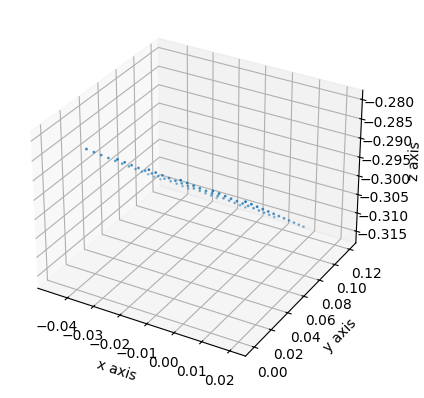

In [41]:
# Train.py (Main) --------------------------------------------------------------

import time
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math

def train(Opt, trainData, validationData):

    # Option
    opt = Opt
    #opt = Options(N_epoch,Init_pattern).parse(save=True, isTrain=True) ## Option 입력

    # Tensorboard
    writer = SummaryWriter(opt.tb_dir)
    print('=================================================================================')
    print('tensorboard output: %s' % opt.tb_dir)
    print('=================================================================================')

    # Image formation & Reconstruction & Trainer
    optics_model = LightDeskRenderer(opt) ## 논문에서 F_I (B * M으로 이미지 랜더링)
    recon_model = Reconstructor(opt) ## 논문에서 F_N (normal map 복원)
    last_epoch = -1 if opt.load_step_start == 0 else opt.load_epoch
    trainer = Trainer(opt, optics_model, recon_model, last_epoch)

    # Step
    total_step = opt.load_step_start
    debug_step = 0

    train_dataset = trainData
    validation_dataset = validationData
    #train_dataset = CreateBasisDataset(opt, 'selected_train_DDPS')
    #validation_dataset = CreateBasisDataset(opt, 'selected_test')

    dataloader_train = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_threads, pin_memory=True) # drop_last=True
    dataloader_valid = DataLoader(validation_dataset, batch_size=opt.batch_size_valid, num_workers=opt.num_threads, pin_memory=True)

    loss_values_for_saving = []
    writerinit = []

    # Save initial patterns
    save_model_pattern(trainer.monitor_light_patterns, 0, total_step, os.path.join(opt.tb_dir, 'patterns'))
    #utils.save_model_pattern(trainer.monitor_light_patterns, 0, total_step, os.path.join(opt.tb_dir, 'patterns'))
    save_model_position(trainer.monitor_superpixel_positions, 0, total_step, os.path.join(opt.tb_dir, 'positions'))
    visualize_patterns(opt, trainer.monitor_light_patterns.data.cpu())

    # Training
    for epoch in range(1, opt.n_epoch+1):

        # Validation @@@@
        if debug_step%1==0:
            valid_loss_sum = 0
            for i, data_ in enumerate(dataloader_valid):
                with torch.no_grad():
                    model_results = trainer.run_model(data_)
                loss = sum(model_results['losses'].values())
                valid_loss_sum += loss
                if i == 0:
                  display_pattern(opt, writer, model_results, total_step, 'valid', os.path.join(opt.tb_dir, 'validation'),trainer.monitor_light_patterns)
                for j in range(len(data_['scene'])):
                    display(opt, writer, model_results, total_step, f'valid{i}', j, os.path.join(opt.tb_dir, 'validation'),trainer.rendered_image,trainer.rendered_error)
                    #utils.display(writer, model_results, total_step, f'valid{i}', j, os.path.join(opt.tb_dir, 'validation'),trainer.monitor_light_patterns)

                if i == opt.valid_N-1:
                    break
            valid_loss_sum /= opt.valid_N
            loss_values_for_saving.append(valid_loss_sum.item())
            writer.add_scalar('valid/loss', valid_loss_sum, total_step)
            writer.add_scalar('superpixel_translate/X', trainer.superpixel_translate[0], total_step)
            writer.add_scalar('superpixel_translate/Y', trainer.superpixel_translate[1], total_step)
            writer.add_scalar('superpixel_translate/Z', trainer.superpixel_translate[2], total_step)
            writer.add_scalar('superpixel_rotate/X', trainer.superpixel_rotate[0], total_step)
            writer.add_scalar('superpixel_rotate/Y', trainer.superpixel_rotate[1], total_step)
            writer.add_scalar('superpixel_rotate/Z', trainer.superpixel_rotate[2], total_step)
        train_loss_sum = 0
        for data in tqdm(dataloader_train, leave=False):
            batch_size = len(data['scene'])

            # Run a optimization step
            trainer.run_optimizers_one_step(data)

            loss_dict = trainer.get_losses()
            loss = sum(loss_dict.values()).data
            train_loss_sum += loss*batch_size

            total_step += batch_size
            debug_step += 1

            save_model_pattern(trainer.monitor_light_patterns, epoch, total_step, os.path.join(opt.tb_dir, 'patterns'))
            #utils.save_model_pattern(trainer.monitor_light_patterns, epoch, total_step, os.path.join(opt.tb_dir, 'patterns'))
            save_model_position(trainer.monitor_superpixel_positions, epoch, total_step, os.path.join(opt.tb_dir, 'positions'))
            writer.add_scalar('train', loss, total_step)
        trainer.run_schedulers_one_step()

        writer.add_scalar('train/batch', train_loss_sum/len(train_dataset), total_step)
        print_training_status(epoch, opt.n_epoch, total_step, debug_step)
        #utils.print_training_status(epoch, opt.n_epoch, total_step, debug_step)
        visualize_patterns(opt, trainer.monitor_light_patterns.data.cpu())

    loss_np = np.array(loss_values_for_saving)
    np.save(os.path.join(opt.tb_dir, f'{opt.initial_pattern}_{opt.used_loss}_optmization_loss_valid'), loss_np)
    writer.close()

    # Save Pattern Imgs
    Pattern = torch.sigmoid(trainer.monitor_light_patterns)
    Pattern = Pattern.detach().cpu().numpy()
    for i in range(opt.light_N):
        Ptmp = cv2.cvtColor((Pattern[i]*255).astype(np.uint8),cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(opt.tb_dir, f'model_imgs/P00{i}.png'), Ptmp)
        Dtmp = np.zeros((2340,1080,3)) # 6x12 -> 1080x2340 (0,90,size=180)
        for y in range(opt.light_R):
          for x in range(opt.light_C):
            Dtmp[90+y*180:90+(y+1)*180,x*180:(x+1)*180] = Ptmp[y][x]
        cv2.imwrite(os.path.join(opt.tb_dir, f'model_imgs/D00{i}.png'), Dtmp)

    # Visualize light Positions
    cloud = trainer.monitor_superpixel_positions.detach().cpu().numpy()
    for i in range(opt.light_R):
          for j in range(opt.light_C):
              X, Y, Z = cloud[i, j, 0], cloud[i, j, 1], cloud[i, j, 2]
              # Rotate(Z)
              X, Y = X*math.cos(trainer.superpixel_rotate[2])-Y*math.sin(trainer.superpixel_rotate[2]), X*math.sin(trainer.superpixel_rotate[2])+Y*math.cos(trainer.superpixel_rotate[2])
              # Rotate(Y)
              X, Z = X*math.cos(trainer.superpixel_rotate[1])-Z*math.sin(trainer.superpixel_rotate[1]), X*math.sin(trainer.superpixel_rotate[1])+Z*math.cos(trainer.superpixel_rotate[1])
              # Rotate(X)
              Y, Z = Y*math.cos(trainer.superpixel_rotate[0])-Z*math.sin(trainer.superpixel_rotate[0]), Y*math.sin(trainer.superpixel_rotate[0])+Z*math.cos(trainer.superpixel_rotate[0])
              # Translate
              X += trainer.superpixel_translate[0]
              Y += trainer.superpixel_translate[1]
              Z += trainer.superpixel_translate[2]
              cloud[i, j, 0] = X
              cloud[i, j, 1] = Y
              cloud[i, j, 2] = Z

    ax = plt.axes(projection='3d')
    ax.view_init(30, -60)
    ax.axis("on")
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    ax.scatter(cloud[:,:,0], cloud[:,:,1], cloud[:,:,2],cmap=plt.cm.coolwarm,s=1)
    plt.show()


# Main
opt = Options(60,'grouped_OLAT').parse(save=True, isTrain=True)
train_dataset = CreateBasisDataset(opt, 'selected_train_DDPS')
validation_dataset = CreateBasisDataset(opt, 'selected_test')

train(opt,train_dataset,validation_dataset)
 # tri_random,gray_noise,mono_random,mono_gradient,tri_gradient,mono_comnplementary,tri_comnplementary,OLAT,grouped_OLAT
